## 推荐系统

根据用户的喜好推荐相关的项目， 有历史记录来决定
主要的技术：  
协同过滤：该方法通过收集多个用户的偏好或偏好信息(协作)来自动预测(过滤)用户的兴趣。  
基于内容的过滤：此方法仅使用用户之前的描述和信息，推荐类似的项目。特备的，将各种候选项与用户先前评分进行比较，推荐最佳匹配项。  
混合方法：以上两种方法的结合，比单纯的一种方法要好。尤其适合解决一些常见的问题，比如冷启动和稀疏问题。  

## 展示如何实现上述三种方法

In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

### 加载数据

In [2]:
articles_df = pd.read_csv('./datasets/shared_articles.csv')
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']

In [3]:
articles_df.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


In [4]:
interactions_df = pd.read_csv('./datasets/users_interactions.csv')
interactions_df.head(10)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR
6,1465415950,VIEW,-8864073373672512525,3609194402293569455,1143207167886864524,NaN,NaN,NaN
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
8,1465413762,VIEW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
9,1465413771,VIEW,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN


### 数据清理

In [5]:
# 根据事件类型表示兴趣程度，比如comment 是最感兴趣的
event_type_strength = {
    'VIEW':1.0,
    'LIKE':2.0,
    'BOOKMARK':2.5,
    'FOLLOW':3.0,
    'COMMENT CREATED':4.0
}

In [6]:
interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: 
                                                                      event_type_strength[x])

推荐系统的冷启动：对缺少足够信息的新用户难以做出个性化的推荐。  
因为这个原因，只保留至少有5次交互的用户信息。

In [23]:
user_interactions_count_df = interactions_df.groupby(['personId', 'contentId']).size().groupby('personId').size()

In [24]:
# 针对不同用户的交互进行分组统计
print("# user: %d" % len(user_interactions_count_df))

# user: 1895


In [25]:
# 选择大于5的用户
user_with_enough_interactions_df = user_interactions_count_df[
    user_interactions_count_df >= 5].reset_index()[['personId']]

In [26]:
print('# users with at least 5 interactions: %d' % len(user_with_enough_interactions_df))

# users with at least 5 interactions: 1140


In [27]:
print("# of interactions: %d" % len( interactions_df))

# 根据后者选出的personId对全集进行合并，得到交互多于5次用户的记录
interactions_from_selected_users_df = interactions_df.merge(user_with_enough_interactions_df, 
                                                           how='right',
                                                           left_on = 'personId', 
                                                           right_on='personId')

# of interactions: 72312


In [28]:
interactions_from_selected_users_df.shape

(69868, 9)

由于用户可能会对文章进行不用的交互，比如多次查看，喜欢和评论。  
因此对用户感兴趣的文章的建模，可根据用户交互强度进行加权聚合，并进行log转换，平滑分布。

In [29]:
def smooth_user_preference(x):
    return math.log(1 + x, 2)

In [31]:
interactions_full_df = interactions_from_selected_users_df.groupby(['personId', 'contentId']) \
                                ['eventStrength'].sum().apply(smooth_user_preference).reset_index()  
interactions_full_df.shape

(39106, 3)

## 评估

评估是机器学习中非常重要的一环，因为需要比较不同的算法及其超参数。  
评估的一个关键方面是，通过交叉验证技术，确保经过训练的模型对未训练的数据进行泛化。  
这里使用一种简单的方式，holdout， 随机选取(20%)的数据用于测试评估。    
另一种方式是由时间来区分，比如选取某个时间之前的数据用于训练，用于预测后续的数据。  

In [33]:
interactions_full_df = interactions_full_df[:1000]
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df, stratify=
                                                              interactions_full_df['personId'], 
                                                              test_size=0.2)

In [34]:
interactions_train_df.shape, interactions_test_df.shape

((800, 3), (200, 3))

在推荐系统中，有多种评估的方法，这里选择top-n accuracy metrics：评估提供给用户的top推荐数目，与测试集中的进行比较。
过程如下：
* 对于每个用户：
   * 对于测试集中用户交互过的每一项:  
       * 取该用户从未交互过的100项: 这里假设非交互项与用户无关，可能并不是事实。
       * 从包含一个交互项和100为交互项的数据集中， 推荐模型产生一个推荐列表。
       * 从推荐列表中， 计算该用户及其交互项的top-n accuracy metrics.
   * 合并全部的top-n分数。(recall)

In [36]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')

In [38]:
interactions_train_indexed_df.shape, interactions_test_indexed_df.shape

((800, 2), (200, 2))

In [53]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [66]:
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100
class ModelEvaluator:
    count = 0
    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        # 产生100条于persion_id 无交互的文章id
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(articles_df['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)
    
    # 查看是否在topn中，比如top5， top10.
    def _verify_hit_top_n(self, item_id, recommended_items, topn):  
            # 求出相等的下标，看是否在topn之间。
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn)) # 表示判断，存在与否

            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        # 测试集中与person交互的content
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        # 根据不同模型的算法推荐出一个列表， 忽略训练集中的数据
        person_recs_df = model.recommend_items(person_id,
                                               items_to_ignore=get_items_interacted(
                                                   person_id,interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=42)

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))
            
            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)] 
            valid_recs = valid_recs_df['contentId'].values

            
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)
        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()

# 计算最受欢迎的项目
item_popularity_df = interactions_full_df.groupby('contentId')['eventStrength'].sum().sort_values(
    ascending=False).reset_index()
item_popularity_df.head(10)

class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventStrength', 'contentId', 'title', 'url', 'lang']]
        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, articles_df)

print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)

Evaluating Popularity recommendation model...
19 users processed


In [67]:
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)


Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.37, 'recall@10': 0.63}


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
4,-9016528795238256703,40,25,68,0.588235,0.367647
0,-9009798162809551896,44,24,57,0.771930,0.421053
5,-8860671864164757449,5,2,10,0.500000,0.200000
14,-9223121837663643404,7,6,9,0.777778,0.666667
1,-9109785559521267180,5,2,9,0.555556,0.222222
8,-9001583565812478106,4,0,8,0.500000,0.000000
3,-9047547311469006438,4,3,5,0.800000,0.600000
12,-8994220765455693336,2,1,5,0.400000,0.200000
2,-9120685872592674274,5,4,5,1.000000,0.800000
15,-9172914609055320039,3,2,5,0.600000,0.400000


## 基于内容的过滤模型

In [68]:
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

In [69]:
vertorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0.003, 
                            max_df=0.5, max_features=5000, stop_words=stopwords_list)

In [70]:
item_ids = articles_df['contentId'].tolist()
tfidf_matrix = vertorizer.fit_transform(articles_df['title'] + "" + articles_df['text'])
tfidf_features_name = vertorizer.get_feature_names()
tfidf_matrix

<3047x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 638928 stored elements in Compressed Sparse Row format>

In [71]:
tfidf_features_name  #5000

['00',
 '000',
 '04',
 '05',
 '10',
 '10 000',
 '10 years',
 '100',
 '100 000',
 '11',
 '12',
 '13',
 '14',
 '15',
 '150',
 '16',
 '17',
 '18',
 '19',
 '20',
 '200',
 '2000',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2020',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '300',
 '31',
 '32',
 '33',
 '34',
 '35',
 '360',
 '37',
 '3d',
 '40',
 '400',
 '42',
 '45',
 '48',
 '49',
 '50',
 '500',
 '52',
 '53',
 '55',
 '60',
 '64',
 '70',
 '75',
 '80',
 '800',
 '85',
 '90',
 '95',
 '99',
 'abaixo',
 'aberta',
 'aberto',
 'abertura',
 'ability',
 'able',
 'abordagem',
 'abril',
 'abrir',
 'absolutely',
 'abstract',
 'abstraction',
 'acaba',
 'academic',
 'accelerate',
 'accelerated',
 'accenture',
 'accept',
 'acceptance',
 'accepted',
 'access',
 'accessibility',
 'accessible',
 'accomplish',
 'according',
 'accordingly',
 'account',
 'accounts',
 'accuracy',
 'accurate',
 'accurately',
 'acessar',
 'acesso',
 '

In [72]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

In [73]:
def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

In [74]:
def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1, 1)
    user_item_strengths_weights_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weights_avg)
    return user_profile_norm

In [75]:
def build_user_profiles():
    interactions_indexed_df = interactions_full_df[interactions_full_df['contentId'].isin(articles_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [76]:
user_profiles = build_user_profiles()

In [77]:
myprofile = user_profiles[-9223121837663643404]
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_features_name, user_profiles[-9223121837663643404]
                        .flatten().tolist()), key=lambda x: -x[1])[:20], columns=['token', 'relevance'])

(1, 5000)


,token,relevance
0,google,0.264311
1,android,0.134612
2,teste,0.117203
3,code,0.113804
4,cloud,0.105702
5,espresso,0.104444
6,app,0.097841
7,apple,0.096864
8,digital,0.093107
9,candidate,0.088624


In [78]:
class ContentBaseRecommender:
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, item_df=None):
        self.item_df = item_df
        self.item_ids = item_ids
    def get_model_name(self):
        return self.MODEL_NAME
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        cosine_similarties = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        similar_indices = cosine_similarties.argsort().flatten()[-topn:]
        similat_items = sorted([(item_ids[i], cosine_similarties[0, i]) for i in similar_indices], 
                              key=lambda x: -x[1])
        return similat_items
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        similar_items_filtered = list(filter(lambda x:x[0] not in items_to_ignore, similar_items))
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]
        return recommendations_df

In [79]:
content_based_recommender_model = ContentBaseRecommender(articles_df)

In [80]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
19 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.255, 'recall@10': 0.34}


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
4,-9016528795238256703,7,2,68,0.102941,0.029412
0,-9009798162809551896,13,7,57,0.228070,0.122807
5,-8860671864164757449,3,2,10,0.300000,0.200000
14,-9223121837663643404,7,5,9,0.777778,0.555556
1,-9109785559521267180,4,4,9,0.444444,0.444444
8,-9001583565812478106,3,1,8,0.375000,0.125000
3,-9047547311469006438,4,4,5,0.800000,0.800000
12,-8994220765455693336,5,4,5,1.000000,0.800000
2,-9120685872592674274,4,4,5,0.800000,0.800000
15,-9172914609055320039,3,3,5,0.600000,0.600000


## 协同过滤（CF）

In [83]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='eventStrength').fillna(0)

users_items_pivot_matrix_df.head(10)

contentId,-9216926795620865886,-9192549002213406534,-9176143510534135851,-9160910454530522563,-9102431381393428051,-9076501258717815738,-9033211547111606164,-9019233957195913605,-8992803137960175254,-8992201526199201450,...,8881733945001664941,8886002764685330098,8912004903894879756,8938071859536254465,8947914348334479785,8962537427807366481,8974280745225397183,9028580484484026894,9042192299854648021,9175693555063886126
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
-9207251133131336884,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2.321928
-9188188261933657343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
-9172914609055320039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,1.584963,0.0,0.0,0.0,0.000000
-9156344805277471150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
-9120685872592674274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.087463,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


In [84]:
users_items_pivot_matrix = users_items_pivot_matrix_df.as_matrix()
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [109]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[-9223121837663643404,
 -9212075797126931087,
 -9207251133131336884,
 -9199575329909162940,
 -9196668942822132778,
 -9188188261933657343,
 -9172914609055320039,
 -9156344805277471150,
 -9120685872592674274,
 -9109785559521267180]

In [110]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [111]:
U.shape, Vt.shape

((20, 15), (15, 667))

In [112]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [113]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[-6.71646747e-06,  5.56883588e-06,  5.56883588e-06, ...,
         5.56883588e-06,  2.33782196e-05, -5.36105831e-03],
       [ 9.98631074e-04, -9.05715892e-04, -9.05715892e-04, ...,
        -9.05715892e-04, -1.37870862e-03, -3.04137574e-05],
       [ 1.99999572e+00,  3.66010794e-06,  3.66010794e-06, ...,
         3.66010794e-06,  8.47922179e-06, -6.21156667e-05],
       ...,
       [-2.57053614e-03,  2.08226319e-03,  2.08226319e-03, ...,
         2.08226319e-03,  6.99755900e-03,  4.91112046e-04],
       [-6.15148569e-07,  5.16830681e-07,  5.16830681e-07, ...,
         5.16830681e-07, -3.14232427e-07,  1.26187327e-03],
       [-2.36447922e-06,  1.85788602e-06,  1.85788602e-06, ...,
         1.85788602e-06,  9.68029861e-06, -1.62576848e-03]])

In [119]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,-9063420486253202900,-9060214117327732109,-9047547311469006438,-9016528795238256703,-9009798162809551896,-9001583565812478106,-8994220765455693336,-8909668725653743114,-8891033171626175843,-8860671864164757449
contentId,,,,,,,,,,,,,,,,,,,,
-9216926795620865886,-0.000007,0.000999,1.999996e+00,1.172316e-05,-0.000054,0.000959,-7.119541e-07,-0.000058,-5.521630e-07,-0.000005,-0.000029,1.087344e-15,-0.000131,0.000007,0.000010,0.000050,-2.544291e-06,-0.002571,-6.151486e-07,-2.364479e-06
-9192549002213406534,0.000006,-0.000906,3.660108e-06,-9.575541e-06,0.000039,-0.001080,4.647854e-07,0.000052,4.659624e-07,0.000004,0.000023,-2.388494e-17,0.000147,0.999994,-0.000007,-0.000043,1.988106e-06,0.002082,5.168307e-07,1.857886e-06
-9176143510534135851,0.000006,-0.000906,3.660108e-06,-9.575541e-06,0.000039,-0.001080,4.647854e-07,0.000052,4.659624e-07,0.000004,0.000023,-2.388494e-17,0.000147,0.999994,-0.000007,-0.000043,1.988106e-06,0.002082,5.168307e-07,1.857886e-06
-9160910454530522563,0.000167,0.000393,3.966490e-05,-1.837571e-04,0.043847,-0.011492,4.710891e-06,0.000048,5.414381e-06,0.000158,0.000358,1.070433e-16,-0.002320,-0.000067,-0.000231,1.583238,3.361633e-05,0.025891,-1.867088e-05,5.265654e-05
-9102431381393428051,0.000002,0.000270,-7.564579e-07,1.192380e-07,0.001337,0.000026,-2.523154e-07,-0.000015,-9.035357e-08,0.000002,-0.000003,-2.493438e-15,-0.000125,0.000001,-0.000002,-0.000029,-2.128302e-07,-0.000495,2.459431e+00,4.531310e-07
-9076501258717815738,0.000146,0.000173,-6.556092e-05,-1.002647e-04,0.087359,0.129167,4.243900e-05,0.000060,-4.848428e-06,0.000165,0.000262,-9.437530e-17,0.975048,0.000147,-0.000770,-0.001464,5.976263e-05,-0.003339,-5.083897e-05,8.757785e-05
-9033211547111606164,0.000018,-0.000473,4.819114e-06,-2.600766e-05,0.003299,0.003709,3.272866e-06,0.000037,7.709615e-07,0.000016,0.000065,2.214260e-16,-0.000770,-0.000007,0.999950,-0.000146,7.079141e-06,0.004915,-8.310631e-07,7.822413e-06
-9019233957195913605,0.000039,-0.002561,1.495833e-05,-6.037224e-05,0.005306,0.003719,6.116941e-06,0.000162,2.153870e-06,0.000033,0.000149,3.031820e-16,-0.000927,1.999977,1.584870,-0.000316,1.519639e-05,0.011955,-2.835425e-07,1.611400e-05
-8992803137960175254,-0.000002,0.000359,-1.797388e-06,5.259597e-06,0.000387,-0.000190,-6.419394e-07,-0.000021,-2.439287e-07,-0.000001,-0.000015,-1.927461e-15,-0.000014,0.000003,0.000006,0.000010,-1.393345e-06,-0.001336,1.999999e+00,9.999989e-01


In [120]:
cf_preds_df.columns

Int64Index([-9223121837663643404, -9212075797126931087, -9207251133131336884,
            -9199575329909162940, -9196668942822132778, -9188188261933657343,
            -9172914609055320039, -9156344805277471150, -9120685872592674274,
            -9109785559521267180, -9063420486253202900, -9060214117327732109,
            -9047547311469006438, -9016528795238256703, -9009798162809551896,
            -9001583565812478106, -8994220765455693336, -8909668725653743114,
            -8891033171626175843, -8860671864164757449],
           dtype='int64')

In [122]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, articles_df)

In [123]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
19 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.05, 'recall@10': 0.125}


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
4,-9016528795238256703,8,4,68,0.117647,0.058824
0,-9009798162809551896,7,2,57,0.122807,0.035088
5,-8860671864164757449,2,0,10,0.200000,0.000000
14,-9223121837663643404,1,1,9,0.111111,0.111111
1,-9109785559521267180,1,0,9,0.111111,0.000000
8,-9001583565812478106,1,1,8,0.125000,0.125000
3,-9047547311469006438,1,0,5,0.200000,0.000000
12,-8994220765455693336,0,0,5,0.000000,0.000000
2,-9120685872592674274,0,0,5,0.000000,0.000000
15,-9172914609055320039,2,1,5,0.400000,0.200000


In [106]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'inner',  #交集
                                   left_on = 'contentId', 
                                   right_on = 'contentId')
        
        #Computing a hybrid recommendation score based on CF and CB scores
        recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF']
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, articles_df)

In [107]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
19 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.215, 'recall@10': 0.255}


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
4,-9016528795238256703,15,14,68,0.220588,0.205882
2,-9009798162809551896,7,7,57,0.122807,0.122807
3,-8860671864164757449,7,5,10,0.700000,0.500000
0,-9109785559521267180,2,2,9,0.222222,0.222222
10,-9223121837663643404,4,4,9,0.444444,0.444444
5,-9001583565812478106,3,2,8,0.375000,0.250000
6,-9120685872592674274,1,0,5,0.200000,0.000000
7,-8994220765455693336,2,0,5,0.400000,0.000000
8,-9047547311469006438,4,4,5,0.800000,0.800000
1,-9172914609055320039,3,3,5,0.600000,0.600000


In [108]:
global_metrics_df = pd.DataFrame([pop_global_metrics, cf_global_metrics, cb_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@10,recall@5
modelName,,
Popularity,0.590,0.330
Collaborative Filtering,0.265,0.155
Content-Based,0.390,0.315
Hybrid,0.255,0.215


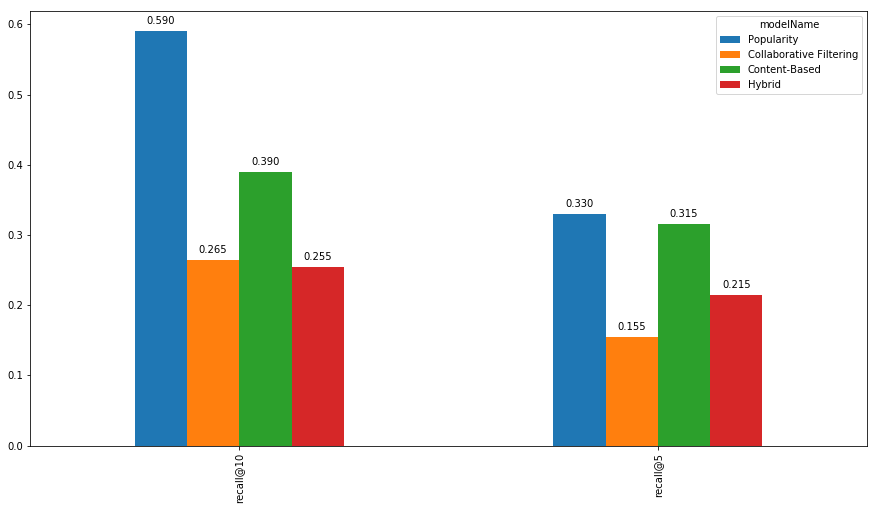

In [109]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [110]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    return interactions_df.loc[person_id].merge(articles_df, how = 'left', 
                                                      left_on = 'contentId', 
                                                      right_on = 'contentId') \
                          .sort_values('eventStrength', ascending = False)[['eventStrength', 
                                                                          'contentId',
                                                                          'title', 'url', 'lang']]